# Get image from the PS1 image server
Query the PS1 image server to get a list of images and retrieve some images.  This sample script demonstrates the use of the PS1 image services.  See the <a href="https://outerspace.stsci.edu/x/ioOc">PS1 Image Cutout Service documentation</a> for details of the services being used.  This notebook is available for 
<a href="https://ps1images.stsci.edu/ps1image.ipynb" download="">download</a>.

In [1]:
%matplotlib notebook
import numpy as np
from astropy.table import Table
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

import aplpy

from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import PercentileInterval, AsinhStretch
from reproject import reproject_interp

/Users/ryanr/anaconda3/lib/python3.5/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


## Helper functions to query the list of images and to extract images

In [2]:
def getimages(ra,dec,size=240,filters="grizy"):
    
    """Query ps1filenames.py service to get a list of images
    
    ra, dec = position in degrees
    size = image size in pixels (0.25 arcsec/pixel)
    filters = string with filters to include
    Returns a table with the results
    """
    
    service = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py"
    url = ("{service}?ra={ra}&dec={dec}&size={size}&format=fits"
           "&filters={filters}").format(**locals())
    table = Table.read(url, format='ascii')
    return table


def geturl(ra, dec, size=240, output_size=None, filters="grizy", format="jpg", color=False):
    
    """Get URL for images in the table
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png" or "fits")
    color = if True, creates a color image (only for jpg or png format).
            Default is return a list of URLs for single-filter grayscale images.
    Returns a string with the URL
    """
    
    if color and format == "fits":
        raise ValueError("color images are available only for jpg or png formats")
    if format not in ("jpg","png","fits"):
        raise ValueError("format must be one of jpg, png, fits")
    table = getimages(ra,dec,size=size,filters=filters)
    url = ("https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?"
           "ra={ra}&dec={dec}&size={size}&format={format}").format(**locals())
    if output_size:
        url = url + "&output_size={}".format(output_size)
    # sort filters from red to blue
    flist = ["yzirg".find(x) for x in table['filter']]
    table = table[np.argsort(flist)]
    if color:
        if len(table) > 3:
            # pick 3 filters
            table = table[[0,len(table)//2,len(table)-1]]
        for i, param in enumerate(["red","green","blue"]):
            url = url + "&{}={}".format(param,table['filename'][i])
    else:
        urlbase = url + "&red="
        url = []
        for filename in table['filename']:
            url.append(urlbase+filename)
    return url


def getcolorim(ra, dec, size=240, output_size=None, filters="grizy", format="jpg"):
    
    """Get color image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filters = string with filters to include
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    url = geturl(ra,dec,size=size,filters=filters,output_size=output_size,format=format,color=True)
    r = requests.get(url)
    im = Image.open(BytesIO(r.content))
    return im


def getgrayim(ra, dec, size=240, output_size=None, filter="g", format="jpg"):
    
    """Get grayscale image at a sky position
    
    ra, dec = position in degrees
    size = extracted image size in pixels (0.25 arcsec/pixel)
    output_size = output (display) image size in pixels (default = size).
                  output_size has no effect for fits format images.
    filter = string with filter to extract (one of grizy)
    format = data format (options are "jpg", "png")
    Returns the image
    """
    
    if format not in ("jpg","png"):
        raise ValueError("format must be jpg or png")
    if filter not in list("grizy"):
        raise ValueError("filter must be one of grizy")
    url = geturl(ra,dec,size=size,filters=filter,output_size=output_size,format=format)
    r = requests.get(url[0])
    im = Image.open(BytesIO(r.content))
    return im

def Rewrite_header_wcs(Fits,wcs):
    newvals = wcs.to_header()
    new_fits = Fits#.copy()
    for key in newvals:
        new_fits[0].header[key] = newvals[key]
    return new_fits

## Sample JPEG images
This gets single-band grayscale and color JPEG images at the position of the Crab Nebula.  The extracted region size is 1280 pixels = 320 arcsec.

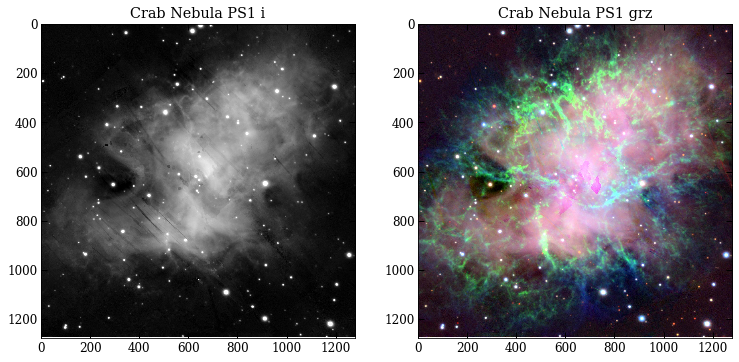

In [3]:
# Crab Nebula position
ra = 83.633210
dec = 22.014460
size = 1280

# grayscale image
gim = getgrayim(ra,dec,size=size,filter="i")
# color image
cim = getcolorim(ra,dec,size=size,filters="grz")

plt.rcParams.update({'font.size':12})
plt.figure(1,(12,6))
plt.subplot(121)
plt.imshow(gim,origin="upper")
plt.title('Crab Nebula PS1 i')
plt.subplot(122)
plt.title('Crab Nebula PS1 grz')
plt.imshow(cim,origin="upper")

## Load and display a FITS image

Note that the $y$-axis is flipped in the JPEG image compared with the original FITS image.

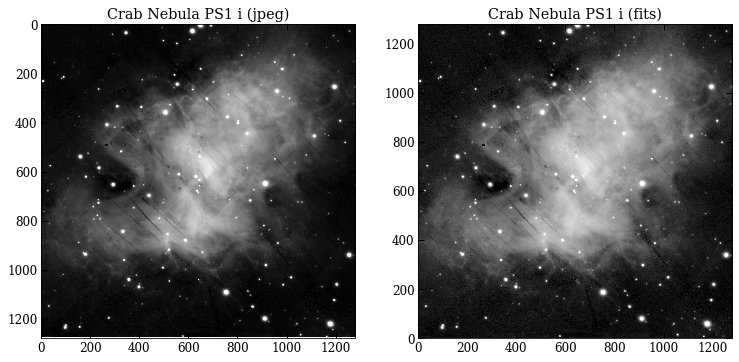

In [4]:


fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])
fim = fh[0].data
# replace NaN values with zero for display
fim[np.isnan(fim)] = 0.0
# set contrast to something reasonable
transform = AsinhStretch() + PercentileInterval(99.5)
bfim = transform(fim)

pylab.figure(1,(12,6))
pylab.subplot(121)
pylab.imshow(gim,origin="upper")
pylab.title('Crab Nebula PS1 i (jpeg)')

pylab.subplot(122)
pylab.title('Crab Nebula PS1 i (fits)')
pylab.imshow(bfim,cmap="gray",origin="lower")

In [9]:
ra = 359
dec = -21
size = 1280*6
fitsurl = geturl(ra, dec, size=size, filters="i", format="fits")
fh = fits.open(fitsurl[0])



In [25]:
path = './Data/test.fits'
#path = '/Users/ryanr/Desktop/new-image.fits'
hdu = fits.open(path)

In [33]:
path = './data/astrom/psimage.fits'#./Data/tess2018235142941-s0002-1-2-0121-s_ffic.fits'
hdu = fits.open(path)
wcstest = WCS('./data/astrom/pswcs.fits')
ps_new = Rewrite_header_wcs(hdu,wcstest)

testtess = fits.open('./data/astrom/tessimage.fits')
wcstess = WCS('./data/astrom/tesswcs.fits')
new_tess = Rewrite_header_wcs(testtess,wcstess)

orig_tess = './Data/test.fits'

In [45]:
np.nanmin(fits.open('./Data/testps.fits')[0].data)

-2.6847663

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


<IPython.core.display.Javascript object>


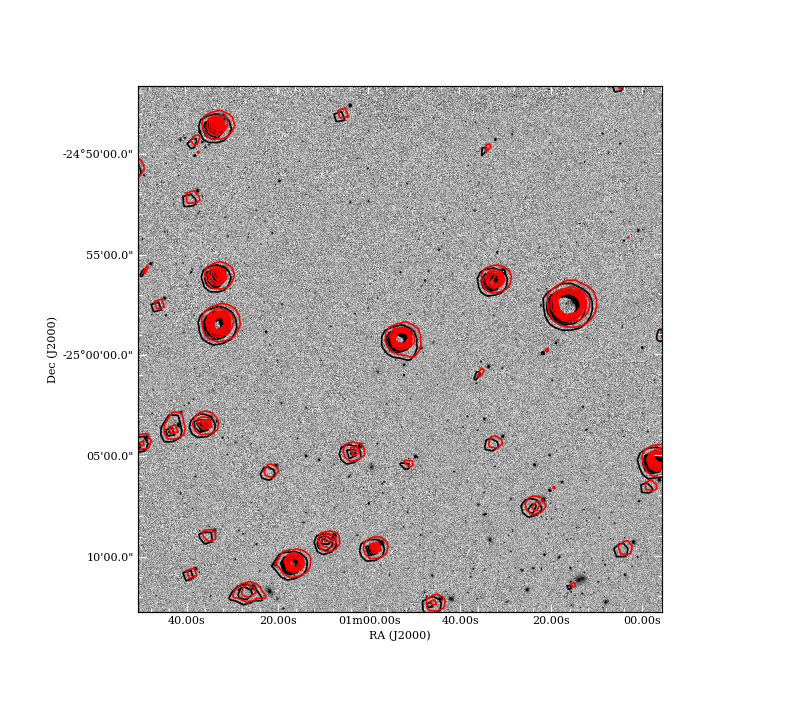

INFO: Auto-setting vmin to -1.629e+00 [aplpy.core]
INFO: Auto-setting vmax to  2.970e+00 [aplpy.core]


/Users/ryanr/anaconda3/lib/python3.5/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]


INFO: Auto-setting resolution to 300 dpi [aplpy.core]


In [48]:
fig = aplpy.FITSFigure(ps_new)
fig.show_colorscale(cmap = 'gray_r')

fig.show_contour(new_tess, levels= 10, colors='k')
fig.show_contour(orig_tess, levels= 10, colors='r')
plt.show()
#fig.recenter(ra, dec, radius=3)
fig.savefig('PS_TESS_contours_Astrometry_comp.pdf')

can try setting the CRPIX to counter the offest in the header.

1. Measure offset distance in RA and DEC
2. Convert to no. of pixels
3. Add to CRPIX1 and 2

In [51]:
rep = reproject_interp(ps_new,new_tess[0].header)

INFO: 
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please append "-SIP" to the CTYPE in the FITS header or the WCS object.

                 [astropy.wcs.wcs]
INFO: 
             

this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]
this form of the PCi_ja keyword is deprecated, use PCi_ja. [astropy.wcs.wcs]


In [56]:
rep[0]

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

<IPython.core.display.Javascript object>


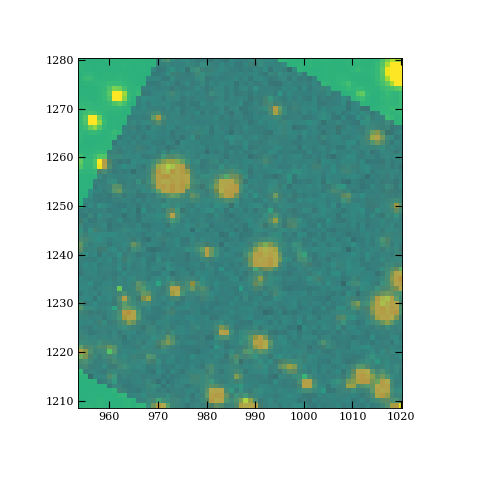

In [64]:
plt.figure()
plt.imshow(new_tess[0].data,origin='lower',vmax = 200)
plt.imshow(rep[0],origin='lower',alpha = 0.4)

In [52]:
fig = aplpy.FITSFigure(rep.)
fig.show_colorscale(cmap = 'gray_r')

fig.show_contour(new_tess, levels= 10, colors='k')
#fig.show_contour(orig_tess, levels= 10, colors='r')
plt.show()
#fig.recenter(ra, dec, radius=3)
#fig.savefig('PS_TESS_contours_Astrometry_comp.pdf')

Exception: data argument should either be a filename, an HDU object from astropy.io.fits, a WCS object from astropy.wcs, or a Numpy array.

In [69]:
from scipy import signal

In [ ]:


lena = misc.lena() - misc.lena().mean()
template = np.copy(lena[235:295, 310:370]) # right eye
template -= template.mean()
lena = lena + np.random.randn(*lena.shape) * 50 # add noise
corr = signal.correlate2d(lena, template, boundary='symm', mode='same')
y, x = np.unravel_index(np.argmax(corr), corr.shape) # find the match

In [84]:
SkyCoord('10h42m44s', '+06d51m06s', frame='icrs')

<SkyCoord (ICRS): (ra, dec) in deg
    (160.68333333, 6.85166667)>